In [59]:
import numpy as np
# from numpy.fft import rfft,irfft
import matplotlib.pyplot as plt

# import pfb
# from datetime import datetime as dt
import pickle
# import time
import os
import copy
import re

In [25]:
# os.listdir("./snrdata")

In [2]:
with open("snrdata/seed_1000438_nepoch_32_log2lenepoch_25_2024-12-07 22:50:47.718398_snr_measurement.pkl","rb") as f:
    pkl=pickle.load(f)
print(pkl.keys())
# pkl["wien"].keys()
pkl["nofilt"]['CONSTS']

dict_keys(['wien', 'nofilt', 'fp', 'cg_1perc', 'cg_3perc', 'cg_5perc', 'cg_10perc'])


{'N_EPOCHS': 32,
 'LEN_EPOCH': 33554432,
 'DELTA_4BIT': 0.353,
 'NFRAME': 2048,
 'NTAP': 4,
 'UPCHAN_FACTOR': 32,
 'TD_NOISE_SIGMA': 10,
 'PRNG_SEED': 1000438,
 'WIENER_THRESH': 0.1,
 'DROP_NROWS': 4}

In [151]:
class CorrelatedProduct:
    @classmethod
    def combine_products(cls, *correlated_products):
        """Combine multiple CorrelatedProducts into a single CorrelatedProduct
        
        Takes an arbitrary number of CorrelatedProduct instances, 
        fails if they are incompatible (must have all same kwargs and CONSTS).
        """
        cp0 = correlated_products[0]
        kwargs=cp0.kwargs
        consts=copy.deepcopy(cp0.consts)
        prng_seeds=[consts.pop('PRNG_SEED')]
        corrmean=list(cp0.corrmean)
        # iterate through remaining correlated products, make sure copatible, add them
        for cp in correlated_products[1:]:
            assert kwargs==cp.kwargs
            cws=copy.deepcopy(cp.consts)
            prng_seeds.append(cws.pop('PRNG_SEED'))
            assert consts==cws, f"consts:{consts}\ncws:{cws}"
            corrmean.extend(list(cp.corrmean))
        initdict={
            "kwargs":kwargs,
            "CONSTS":consts,
            "corrmean":corrmean,
        }
        # print(corrmean)
        # make sure no repeated seeds
        assert len(set(prng_seeds))==len(prng_seeds), "Duplicate PRNG seeds detected"
        initdict["CONSTS"]["PRNG_SEEDS"]=None
        return cls(initdict)
    def __init__(self,data_dict):
        self.kwargs = data_dict['kwargs']
        self.consts = data_dict['CONSTS']
        self.corrmean = np.array(data_dict['corrmean'])
        return
    def __str__(self):
        outstr =f"Epochs\t\t{self.consts['N_EPOCHS']}\n"
        outstr+=f"Log2 length\t{np.log2(self.consts['LEN_EPOCH']):.2f}\n"
        outstr+=f"Frame length\t{self.consts['NFRAME']}\n"
        outstr+=f"Num taps\t{self.consts['NTAP']}\n"
        outstr+=f"Upchan factor\t{self.consts['UPCHAN_FACTOR']}"
        return outstr
    def integrity_checks(self):
        for keyname in data_dict.keys():
            assert keyname in ('kwargs','CONSTS','corrmean'), f'Invalid keyname detected {keyname}'
        return
    def compute_stats(self,printalt=1):
        self.sample_mean = self.corrmean.mean()
        n=len(self.corrmean)
        # self.sample_std = np.sqrt( np.sum((self.sample_mean - self.corrmean)**2) / (len(self.corrmean)-1) )
        self.sample_std = self.corrmean.std() * np.sqrt(n/(n-1))
        self.SE_mean = self.sample_std / np.sqrt(n)
        self.SE_std = self.sample_std / np.sqrt(2 * n)
        self.snr = np.sqrt(self.sample_mean**2)/np.sqrt(self.sample_std**2)
        self.snr_err = self.snr * np.sqrt((self.SE_mean/self.sample_mean)**2 + (self.SE_std/self.sample_std)**2)
        return self.get_stats_string(printalt)
    def get_stats_string(self, alt=1):
        if alt==0:ss=f"\
Sample mean             : {self.sample_mean:.2e} ± {self.SE_mean:.2e} \t({100*self.SE_mean/self.sample_mean:.3f}%)\n\
Sample STD              : {self.sample_std:.2e} ± {self.SE_std:.2e} \t({100*self.SE_std/self.sample_std:.2f}%)\n\
SNR (sqrt x^2/std^2)    : {self.snr:.4e} ± {self.snr_err:.2e} \t({100*self.snr_err/self.snr:.2f}%)"
        elif alt==1:ss=f"\
Sample mean             : {np.real(self.sample_mean):.2e} ± {np.real(self.SE_mean):.2e} \t({100*self.SE_mean/self.sample_mean:.3f}%)\n\
Sample STD              : {np.real(self.sample_std):.2e} ± {np.real(self.SE_std):.2e} \t({100*self.SE_std/self.sample_std:.2f}%)\n\
SNR (sqrt x^2/std^2)    : {np.real(self.snr):.2e} ± {np.real(self.snr_err):.2e} \t({100*self.snr_err/self.snr:.2f}%)"
        elif alt==2:ss=f"\
Sample mean             : {np.real(self.sample_mean):.2f}\n\
Sample STD              : {np.real(self.sample_std):.2f}\n\
SE in mean              : {np.real(self.SE_mean):.2e}\n\
SE in std               : {np.real(self.SE_std):.2e}\n\
SNR                     : {np.real(self.snr):.2e}\n\
SNR error               : {np.real(self.snr_err):.2e}"
        elif alt==3:ss=f"\
Sample mean & Sample STD & SE in mean & SE in std \n\
{np.real(self.sample_mean):.2f} & {np.real(self.sample_std):.2f} & {np.real(self.SE_mean):.2f} & {np.real(self.SE_std):.2f}"
        elif alt==4:ss=f"\
Sample mean & Sample STD & SE in mean & SE in std \n\
{np.real(self.sample_mean):.5f} & {np.real(self.sample_std):.5f} & {np.real(self.SE_mean):.5f} & {np.real(self.SE_std):.5f}"
        elif alt==5:ss=f"\
Sample mean & Sample STD & SNR \n\
{np.real(self.sample_mean):.0f} \pm {np.real(self.SE_mean):.0f} & \
{np.real(self.sample_std):.1f} \pm {np.real(self.SE_std):.1f} & \
{np.real(self.snr):.2f} \pm {np.real(self.snr_err):.2f}"
        return ss
    
class PklFileContents:
    def __init__(self, fname):
        with open(fname, 'rb') as f: self.pkl=pickle.load(f)
        self.correlated_products = []
        self.correlated_product_names = []
        for correlated_product_name in ('fp','wien','nofilt','cg_1perc','cg_3perc','cg_5perc','cg_10perc'):
            try: 
                correlated_product = CorrelatedProduct(self.pkl[correlated_product_name])
                setattr(self,correlated_product_name,correlated_product)
                self.correlated_products.append(getattr(self, correlated_product_name))
                self.correlated_product_names.append(correlated_product_name)
            except KeyError:
                pass
        return
    def basic_integrity_checks(self):
        # Not yet implemented
        return
    
def readpklfile(fname):
    return
def readallpkl(fname_regex):
    return

No Filter
Sample mean & Sample STD & SNR 
50829 \pm 109 & 13978.5 \pm 77.2 & 3.64 \pm 0.02
------------------------------
Wien
Sample mean & Sample STD & SNR 
49850 \pm 10 & 1334.8 \pm 7.4 & 37.35 \pm 0.21
------------------------------
FP precision
Sample mean & Sample STD & SNR 
52178 \pm 11 & 1369.4 \pm 7.6 & 38.10 \pm 0.21
------------------------------
Conjugate Gradient 1 percent
Sample mean & Sample STD & SNR 
48112 \pm 10 & 1283.7 \pm 7.1 & 37.48 \pm 0.21
------------------------------
Conjugate Gradient 3 percent
Sample mean & Sample STD & SNR 
48245 \pm 10 & 1285.1 \pm 7.1 & 37.54 \pm 0.21
------------------------------
Conjugate Gradient 5 percent
Sample mean & Sample STD & SNR 
48352 \pm 10 & 1286.2 \pm 7.1 & 37.59 \pm 0.21
------------------------------
Conjugate Gradient 10 percent
Sample mean & Sample STD & SNR 
48442 \pm 10 & 1288.5 \pm 7.1 & 37.60 \pm 0.21
------------------------------


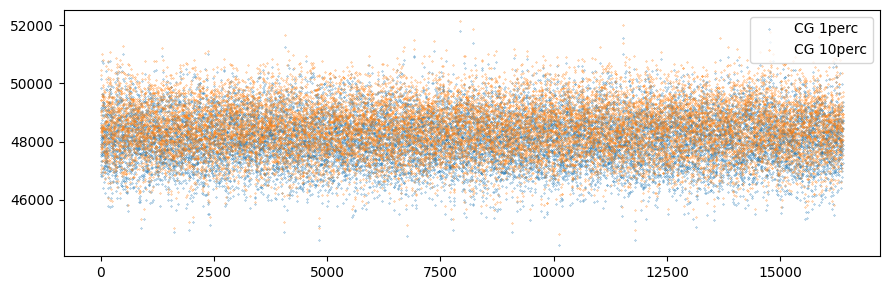

In [152]:
pklfiles=[]
# For each file
for fname in [i for i in os.listdir("./snrdata") if re.match("seed_.*nepoch_32_log2lenepoch_25.*snr_measurement.pkl",i)]:
    fpath = os.path.join(os.getcwd(),"snrdata",fname)
    # Read file into object and add to list
    pklfiles.append(PklFileContents(fpath))
# print(pklfiles)

printline="-"*30
printalt=5


print("No Filter")
nofilt_products = CorrelatedProduct.combine_products(*[pfc.nofilt for pfc in pklfiles])
print(nofilt_products.compute_stats(printalt))
print(printline)

print("Wien")
wien_products = CorrelatedProduct.combine_products(*[pfc.wien for pfc in pklfiles])
print(wien_products.compute_stats(printalt))
print(printline)

print("FP precision")
fp_products = CorrelatedProduct.combine_products(*[pfc.fp for pfc in pklfiles])
print(fp_products.compute_stats(printalt))
print(printline)

print("Conjugate Gradient 1 percent")
cg_1perc_products = CorrelatedProduct.combine_products(*[pfc.cg_1perc for pfc in pklfiles])
print(cg_1perc_products.compute_stats(printalt))
print(printline)

print("Conjugate Gradient 3 percent")
cg_3perc_products = CorrelatedProduct.combine_products(*[pfc.cg_3perc for pfc in pklfiles])
print(cg_3perc_products.compute_stats(printalt))
print(printline)

print("Conjugate Gradient 5 percent")
cg_5perc_products = CorrelatedProduct.combine_products(*[pfc.cg_5perc for pfc in pklfiles])
print(cg_5perc_products.compute_stats(printalt))
print(printline)

print("Conjugate Gradient 10 percent")
cg_10perc_products = CorrelatedProduct.combine_products(*[pfc.cg_10perc for pfc in pklfiles])
print(cg_10perc_products.compute_stats(printalt))
print(printline)

plt.figure(figsize=(9,3))
# plt.plot(nofilt_products.corrmean,'.',markersize=0.5,label="nofilt")
# plt.plot(wien_products.corrmean,'.',markersize=0.5,label="Wien")
# plt.plot(fp_products.corrmean,'.',markersize=0.5,label="Floating Point")
plt.plot(cg_1perc_products.corrmean,'.',markersize=0.5,label="CG 1perc")
# plt.plot(cg_3perc_products.corrmean,'.',markersize=0.5,label="CG 3perc")
# plt.plot(cg_5perc_products.corrmean,'.',markersize=0.5,label="CG 5perc")
plt.plot(cg_10perc_products.corrmean,'.',markersize=0.5,label="CG 10perc")
plt.legend()
plt.tight_layout()
plt.show()

In [135]:
print(np.std(cg_1perc_products.corrmean))
print(np.std(cg_3perc_products.corrmean))
print(np.std(cg_5perc_products.corrmean))
print(np.std(cg_10perc_products.corrmean))

1283.6384041239135
1285.0889433639052
1286.1428896449443
1288.430585454399
